In [1]:
import os
import shapefile as shp
from pyproj import Proj
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.tri as tri

import rasterio
import earthpy.spatial as es

In [2]:
# import PVI txt
set1_fn = "../5_data_processing_v2_after_presentation/2_Set1/4_PIV_64/PIV_1_image_pair.txt"
set2_fn ="../5_data_processing_v2_after_presentation/3_Set2/4_PIV_64/PIV_1_image_pair.txt"
set3_fn = "../5_data_processing_v2_after_presentation/4_Set3/3_PIV_64/PIV_1_image_pair.txt"


# Png
set1_png_fn = '../5_data_processing_v2_after_presentation/2_Set1/1_image_pair/extract2.png'
set2_png_fn ="../5_data_processing_v2_after_presentation/3_Set2/1_image_pair/extract3.png"
set3_png_fn = "../5_data_processing_v2_after_presentation/4_Set3/1_image_pair/extract4.png"

In [3]:
# read data
def read_imJ (txt_fn):
    imJ_results = pd.read_csv(txt_fn, delimiter=' ', header=None)
    
    # drop last column because of NaNs
    imJ_results = imJ_results.iloc[:, :-1] #[rows, columns]
    imJ_results.head()
    
    imJ_header = ['x', 'y', 'ux1','uy1','mag1','ang1','p1','ux2','uy2',
              'mag2','ang2','p2','ux0','uy0','mag0', 'flag']
    
    # update df columns name
    imJ_results.columns = imJ_header
    imJ_results.head()
    
    # select mag ==0 & uy1 (y direction) < 0  (-ve)
    imJ_results_copy = imJ_results.copy()
    indices_mag = imJ_results_copy[imJ_results_copy['mag1'] ==0].index
    indices_y = imJ_results_copy[imJ_results_copy['uy1'] < 0].index
    
    #drop them
    imJ_results_copy.drop(indices_mag,inplace=True)
    imJ_results_copy.drop(indices_y,inplace=True)
    
    indices_mag_small = imJ_results_copy[imJ_results_copy['mag1'] <3].index
    imJ_results_copy.drop(indices_mag_small,inplace=True)
    
    
    return imJ_results_copy


In [4]:
# strain calculation for all points in df
def distance(dataframe): 
    
    dataframe["distance1_2"] = np.sqrt((dataframe["x_match_1"] -dataframe["x_match_2"])**2 + (dataframe["y_match_1"] -dataframe["y_match_2"])**2)
    
    return dataframe.round(2)

def strain (dataframe):
    dataframe["strains"]= dataframe["len_diff"]/dataframe["distance1_2"]
    
    return dataframe.round(2)

#######################################################################
def iter_row(imJ_results):
   # from one point match all other point
    
    import itertools
    
    combination_list = []
    TID_com = list(itertools.combinations(imJ_results.index, 2))
    combination_list.append(TID_com)
    len_com = list(itertools.combinations(imJ_results["mag1"].round(2), 2))
    combination_list.append(len_com)
    x_com = list(itertools.combinations(imJ_results["x"].round(2), 2))
    combination_list.append(x_com)
    y_com = list(itertools.combinations(imJ_results["y"].round(2), 2))
    combination_list.append(y_com)
    
    # put the list in the new df
    df = pd.DataFrame(combination_list).transpose().round(2)
    
    # seperate vectors and rename the df columns
    
    df[["TID_match_1", "TID_match_2"]] = pd.DataFrame(df[0].values.tolist(), index = df.index )
    df[["Len_match_1", "Len_match_2"]] = pd.DataFrame(df[1].values.tolist(), index = df.index)
    df[["x_match_1", "x_match_2"]] = pd.DataFrame(df[2].values.tolist(), index = df.index)
    df[["y_match_1", "y_match_2"]] = pd.DataFrame(df[3].values.tolist(), index = df.index)
    
    # select useful columns
    df = df.iloc[:, 4:]
    
    # Strain 𝑒=Δ𝐿/𝐿0 calculation
    # calculate len difference
    df["len_diff"] = df["Len_match_1"] - df["Len_match_2"]
    
    # calculate distance for two new points and strain
    df = distance(df)
    df = strain(df)
    
    return df
   

In [5]:
# strain plot
def strain_plt (strain_df, png_fn):
    fig = plt.figure(figsize=(15, 7))
    ax = fig.add_subplot(1,1,1)
    png = plt.imread(png_fn)
    ax.imshow(png)

    # sca = ax.scatter(x=df['x_coor_1'],
    #            y=df['y_coor_1'],
    #            s=df['strains']*1000, c = df['strains'], cmap='tab20b', 
    #                  vmin = np.percentile(df['strains'].values, 2), vmax = np.percentile(df['strains'].values, 98),
    #                  alpha=0.8)


    sca = ax.scatter(x=strain_df['x_match_1'],
               y=strain_df['y_match_1'],
                c = strain_df['strains'], cmap='seismic',
                     s=10,
                     vmin = np.percentile(strain_df['strains'].values, 5), 
                     vmax = np.percentile(strain_df['strains'].values, 95),
                     alpha=0.6)


    cbar = plt.colorbar(sca, ax = ax)
    cbar.set_label("Strain")

    ax = plt.gca()
    ax.ticklabel_format(style = 'plain')
    #plt.grid()
    plt.axis("off")
    plt.show()
    return fig

In [6]:
def strain_hist_plt(strain_df):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(1,1,1)
    ax.hist(strain_df["strains"], bins = 20, range=[-0.1, 0.1],color= "darkorange")
    ax.set_xlabel("Strain", fontsize = 12)
    ax.set_ylabel("Accumulation", fontsize = 12)
    plt.grid()
    plt.show()
    
    return fig

# Set 1 dataset

In [7]:
PIV_df = read_imJ(set1_fn)

In [8]:
PIV_df.head()

,x,y,ux1,uy1,mag1,ang1,p1,ux2,uy2,mag2,ang2,p2,ux0,uy0,mag0,flag
4477,872,472,-7.225525,0.259860,7.230196,80.529876,4768564.00,9.000000,-16.00000,18.357560,158.052661,4462077.0,-0.104201,0.801166,0.807914,0
4478,888,472,5.104886,1.234233,5.251970,84.137020,4414287.50,0.000000,-15.00000,15.000000,172.271135,3990684.0,-0.140002,1.031559,1.041016,0
4480,920,472,-0.537226,3.301586,3.345009,17.887390,2935688.75,5.000000,-16.00000,16.763055,154.000620,2770710.0,0.122418,0.805142,0.814396,0
4481,936,472,-0.151525,4.073442,4.076259,60.770736,2573485.25,12.824816,-12.44168,17.868165,75.490826,2507549.0,0.658041,0.401033,0.770614,0
4635,872,488,-0.149329,7.943389,7.944793,1.362163,7046215.00,15.000000,-8.00000,17.000000,120.511632,7015071.0,-0.093363,2.191774,2.193761,0


In [9]:
strain_df = iter_row(PIV_df)

In [10]:
strain_df

,TID_match_1,TID_match_2,Len_match_1,Len_match_2,x_match_1,x_match_2,y_match_1,y_match_2,len_diff,distance1_2,strains
0,4477,4478,7.23,5.25,872,888,472,472,1.98,16.00,0.12
1,4477,4480,7.23,3.35,872,920,472,472,3.88,48.00,0.08
2,4477,4481,7.23,4.08,872,936,472,472,3.15,64.00,0.05
3,4477,4635,7.23,7.94,872,872,472,488,-0.71,16.00,-0.04
4,4477,4636,7.23,8.19,872,888,472,488,-0.96,22.63,-0.04
...,...,...,...,...,...,...,...,...,...,...,...
219448,8029,8161,11.35,6.37,2088,1672,824,840,4.98,416.31,0.01
219449,8029,8323,11.35,13.88,2088,1736,824,856,-2.53,353.45,-0.01
219450,8159,8161,3.56,6.37,1640,1672,840,840,-2.81,32.00,-0.09
219451,8159,8323,3.56,13.88,1640,1736,840,856,-10.32,97.32,-0.11


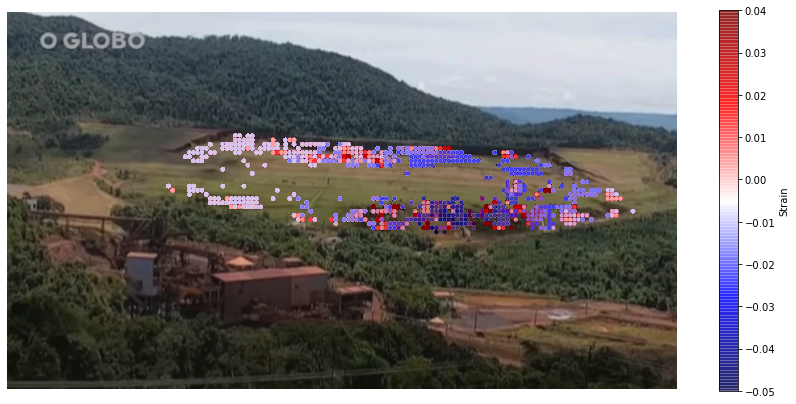

In [11]:
strain_plt(strain_df, set1_png_fn).savefig("../4_python/output_2_newdataset/1_set1_PIV_strain.png")


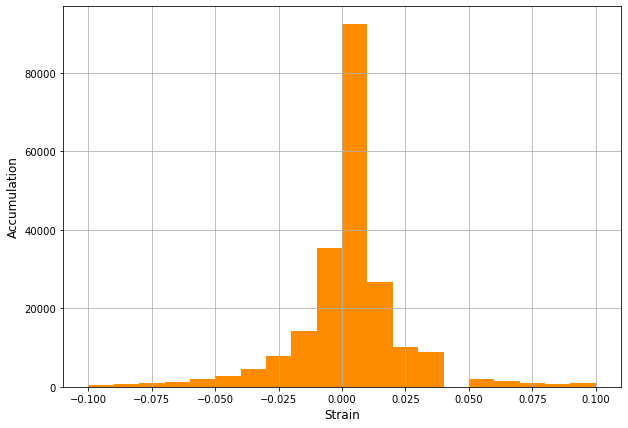

In [12]:
strain_hist_plt(strain_df).savefig("../4_python/output_2_newdataset/1_set1_PIV_strain_hist.png")

# Set 2 dataset

In [13]:
PIV_df = read_imJ(set2_fn)

In [14]:
PIV_df.head()

,x,y,ux1,uy1,mag1,ang1,p1,ux2,uy2,mag2,ang2,p2,ux0,uy0,mag0,flag
4474,824,472,-11.062000,4.491356,11.939016,148.687859,2066220.875,15.000000,5.00000,15.811388,9.220778,2063993.875,0.637593,0.103429,0.645927,0
4475,840,472,1.358466,3.299017,3.567764,64.581283,2334391.750,6.000000,-16.00000,17.088007,72.481830,2297108.250,1.688185,0.089593,1.690561,0
4478,888,472,3.067308,0.033682,3.067493,175.552980,2579874.500,-20.000000,0.00000,20.000000,3.817880,2568932.500,-4.114020,0.274542,4.123170,0
4480,920,472,-0.231445,5.751402,5.756057,3.454596,2007461.000,7.000000,-16.00000,17.464249,155.220446,1995552.875,0.013651,0.679930,0.680067,0
4481,936,472,-0.298565,5.131831,5.140509,48.600769,1996695.875,-2.989925,-13.81291,14.132803,146.942637,1990014.875,0.289727,0.286998,0.407810,0


In [15]:
strain_df = iter_row(PIV_df)

In [16]:
strain_df

,TID_match_1,TID_match_2,Len_match_1,Len_match_2,x_match_1,x_match_2,y_match_1,y_match_2,len_diff,distance1_2,strains
0,4474,4475,11.94,3.57,824,840,472,472,8.37,16.00,0.52
1,4474,4478,11.94,3.07,824,888,472,472,8.87,64.00,0.14
2,4474,4480,11.94,5.76,824,920,472,472,6.18,96.00,0.06
3,4474,4481,11.94,5.14,824,936,472,472,6.80,112.00,0.06
4,4474,4635,11.94,13.66,824,872,472,488,-1.72,50.60,-0.03
...,...,...,...,...,...,...,...,...,...,...,...
322801,8174,8322,12.43,8.26,1880,1720,840,856,4.17,160.80,0.03
322802,8174,8323,12.43,7.38,1880,1736,840,856,5.05,144.89,0.03
322803,8321,8322,5.02,8.26,1704,1720,856,856,-3.24,16.00,-0.20
322804,8321,8323,5.02,7.38,1704,1736,856,856,-2.36,32.00,-0.07


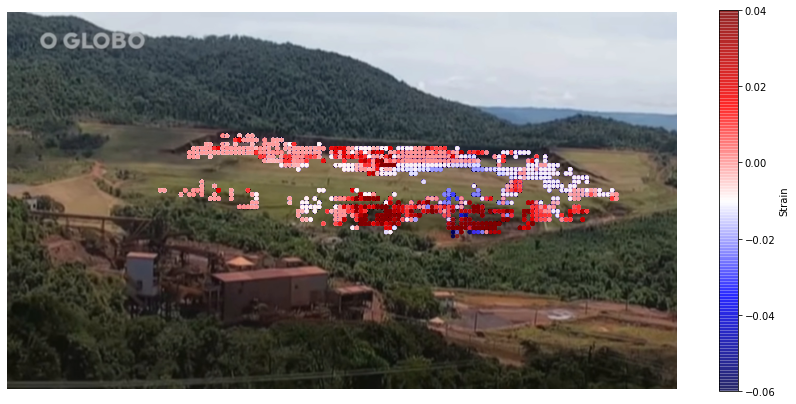

In [17]:
strain_plt(strain_df, set2_png_fn).savefig("../4_python/output_2_newdataset/2_set2_PIV_strain.png")

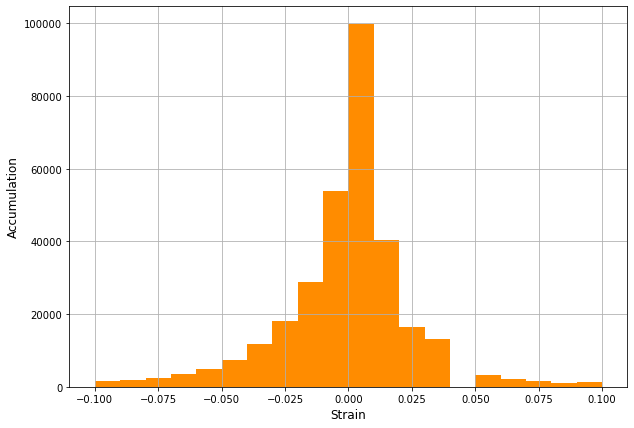

In [18]:
strain_hist_plt(strain_df).savefig("../4_python/output_2_newdataset/2_set2_PIV_strain_hist.png")

# Set 3 dataset

In [19]:
PIV_df = read_imJ(set3_fn)

In [20]:
PIV_df.head()

,x,y,ux1,uy1,mag1,ang1,p1,ux2,uy2,mag2,ang2,p2,ux0,uy0,mag0,flag
4632,824,488,-4.711793,0.385681,4.727551,147.610513,2112575.00,-7.000000,-16.000000,17.464249,141.339390,2062374.000,0.509151,0.267424,0.575109,0
4636,888,488,-18.535437,0.336837,18.538498,0.603600,2966454.75,3.000000,0.000000,3.000000,179.562503,2951610.750,-12.515290,0.095566,12.515655,0
4637,904,488,-3.741819,5.618520,6.750480,54.796396,2469320.75,-4.052603,-12.272072,12.923906,73.266044,2469308.750,-4.505562,0.121193,4.507192,0
4638,920,488,-7.777717,9.215526,12.058971,34.375526,2048030.00,-12.000000,-16.000000,20.000000,68.590891,2035355.000,-0.455947,0.126109,0.473066,0
4639,936,488,-0.792800,9.610203,9.642849,68.530187,2069804.75,-2.000000,-16.000000,16.124515,99.628825,2055287.875,-0.366445,0.110314,0.382689,0


In [21]:
strain_df = iter_row(PIV_df)

In [22]:
strain_df

,TID_match_1,TID_match_2,Len_match_1,Len_match_2,x_match_1,x_match_2,y_match_1,y_match_2,len_diff,distance1_2,strains
0,4632,4636,4.73,18.54,824,888,488,488,-13.81,64.00,-0.22
1,4632,4637,4.73,6.75,824,904,488,488,-2.02,80.00,-0.03
2,4632,4638,4.73,12.06,824,920,488,488,-7.33,96.00,-0.08
3,4632,4639,4.73,9.64,824,936,488,488,-4.91,112.00,-0.04
4,4632,4640,4.73,6.49,824,952,488,488,-1.76,128.00,-0.01
...,...,...,...,...,...,...,...,...,...,...,...
337426,8322,8324,5.70,14.98,1720,1752,856,856,-9.28,32.00,-0.29
337427,8322,8481,5.70,11.34,1720,1736,856,872,-5.64,22.63,-0.25
337428,8323,8324,25.55,14.98,1736,1752,856,856,10.57,16.00,0.66
337429,8323,8481,25.55,11.34,1736,1736,856,872,14.21,16.00,0.89


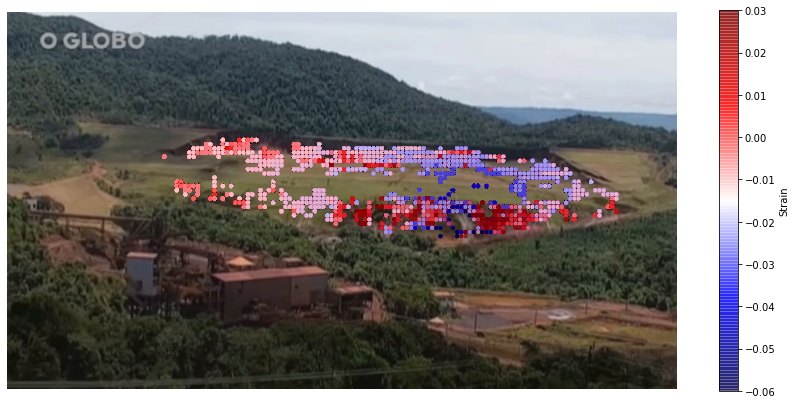

In [23]:
strain_plt(strain_df, set3_png_fn).savefig("../4_python/output_2_newdataset/3_set3_PIV_strain.png")

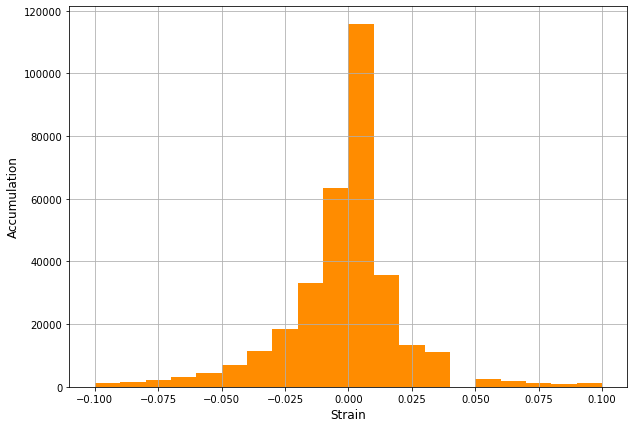

In [24]:
strain_hist_plt(strain_df).savefig("../4_python/output_2_newdataset/3_set3_PIV_strain_hist.png")